Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_jac_hvp_fun

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Generating datapoints  0  to  50


In [5]:
g_obs = np.array(g_obs)

Text(0.5, 0, 'individual')

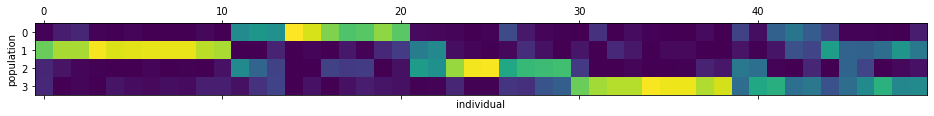

In [6]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [7]:
g_obs.shape

(50, 100, 3)

# Get prior

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [9]:
k_approx = 8

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 8, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_beta] = NumericArrayPattern (50, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [12]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 34221)

Text(0.5, 0, 'individual')

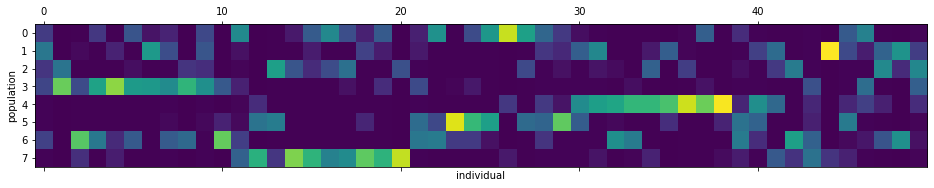

In [13]:
plt.matshow(plotting_utils.get_vb_expectations(vb_params_dict)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [15]:
from vb_lib.structure_optimization_lib import define_structure_objective
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [16]:
optim_objective, init_vb_free = \
    define_structure_objective(g_obs, vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 19762.69009578
Compiling grad ...
Compile time: 19.2203secs


In [17]:
out = run_lbfgs(optim_objective, init_vb_free)

vb_opt = out.x
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)



Running L-BFGS-B ... 
Iter 0: f = 19762.69009578
Iter 1: f = 19241.52676286
Iter 2: f = 17469.07435517
Iter 3: f = 12415.25917376
Iter 4: f = 10481.76491931
Iter 5: f = 9103.77630776
Iter 6: f = 8384.99219370
Iter 7: f = 8059.67286661
Iter 8: f = 7857.29939386
Iter 9: f = 7704.48692361
Iter 10: f = 7636.23657752
Iter 11: f = 7596.27180605
Iter 12: f = 7572.48722471
Iter 13: f = 7556.88395892
Iter 14: f = 7544.80884353
Iter 15: f = 7535.55426703
Iter 16: f = 7527.13195103
Iter 17: f = 7518.04657179
Iter 18: f = 7512.14305219
Iter 19: f = 7507.72469602
Iter 20: f = 7505.09083515
Iter 21: f = 7502.72411137
Iter 22: f = 7499.44307993
Iter 23: f = 7497.17355864
Iter 24: f = 7494.91003964
Iter 25: f = 7490.63313276
Iter 26: f = 7487.06774649
Iter 27: f = 7482.04249984
Iter 28: f = 7479.20450220
Iter 29: f = 7477.48422882
Iter 30: f = 7476.91603185
Iter 31: f = 7476.27228241
Iter 32: f = 7475.47808369
Iter 33: f = 7474.87552865
Iter 34: f = 7474.19431876
Iter 35: f = 7473.78464749
Iter 36: f

# Check out the fit

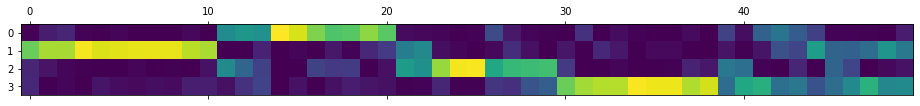

In [18]:
# truth
plt.matshow(true_ind_admix_propn.T)

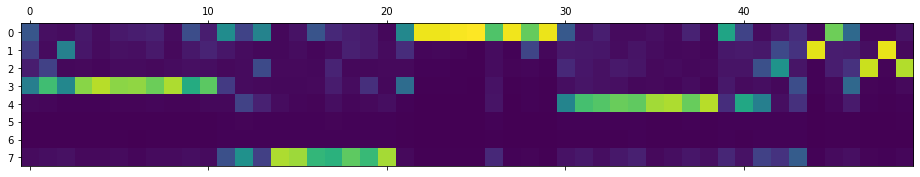

In [19]:
# fitted
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict)[0]
plt.matshow(e_ind_admix.T)

# Define sensitivity object

In [20]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [21]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


In [22]:
objective_fun_free(vb_opt, prior_alpha0)

DeviceArray(7472.42513623, dtype=float64)

### Set up hessian solver

In [23]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True)
t0 = time.time()
_ = cg_precond(vb_opt)
print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 2.56sec


In [24]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        cg_precond=cg_precond)


Compiling hessian solver ...
Hessian solver compile time: 131.782sec

Compiling cross hessian...
Cross-hessian compile time: 3.11377sec

LR sensitivity time: 0.987273sec



# Perturb alpha. Check results

In [27]:
# set new alpha 
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [28]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])


initial alpha,  [3.]
perturbed alpha,  [5.]


In [29]:
# linear response prediction 
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha))

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  4.401820609830777


In [30]:
(lr_vb_free_params**2).mean()

DeviceArray(6.28532857, dtype=float64)

### reoptimize

In [31]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [32]:
optim_objective_pert, _ = \
    define_structure_objective(g_obs, new_init_dict,
                        vb_params_paragami,
                        prior_params_pert_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 7768.77385913
Compiling grad ...
Compile time: 17.5284secs


In [33]:
out = run_lbfgs(optim_objective_pert, new_init_free)

vb_opt_pert = out.x
vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)


Running L-BFGS-B ... 
Iter 0: f = 7768.77385913
Iter 1: f = 7752.85757062
Iter 2: f = 7733.98390624
Iter 3: f = 7726.81663864
Iter 4: f = 7720.95840170
Iter 5: f = 7716.72375083
Iter 6: f = 7715.78459166
Iter 7: f = 7713.18515594
Iter 8: f = 7711.10994680
Iter 9: f = 7708.49179511
Iter 10: f = 7705.54145292
Iter 11: f = 7705.89831817
Iter 12: f = 7704.27500734
Iter 13: f = 7703.72161455
Iter 14: f = 7703.31350823
Iter 15: f = 7703.00615831
Iter 16: f = 7702.96416524
Iter 17: f = 7702.67194766
Iter 18: f = 7702.61628359
Iter 19: f = 7702.49086853
Iter 20: f = 7702.31427250
Iter 21: f = 7702.36884255
Iter 22: f = 7702.20482897
Iter 23: f = 7702.03488551
Iter 24: f = 7701.97026963
Iter 25: f = 7701.93791038
Iter 26: f = 7701.91948310
Iter 27: f = 7701.90272851
Iter 28: f = 7701.88838020
Iter 29: f = 7701.88181221
Iter 30: f = 7701.87476883
Iter 31: f = 7701.86754605
Iter 32: f = 7701.86213282
Iter 33: f = 7701.85970383
Iter 34: f = 7701.85571374
Iter 35: f = 7701.85444455
Iter 36: f = 77

### compare

In [34]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


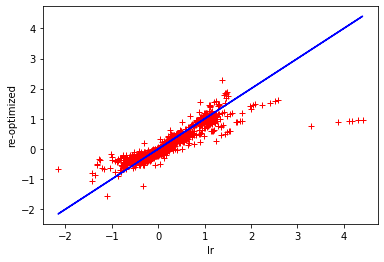

In [35]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [36]:
# compare expectations
init_e_ind_admix, init_e_pop_freq = plotting_utils.get_vb_expectations(vb_opt_dict)
pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(vb_pert_dict)
lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(
    vb_params_paragami.fold(lr_vb_free_params, free = True))

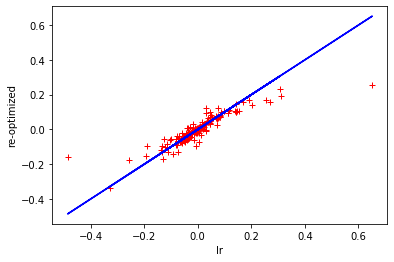

In [37]:
print_diff_plot(lr_e_ind_admix, pert_e_ind_admix, init_e_ind_admix)

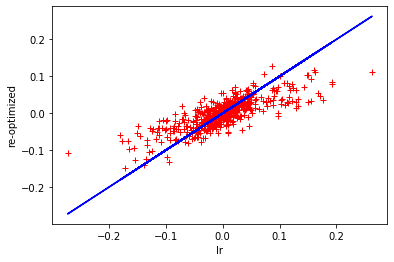

In [38]:
print_diff_plot(lr_e_pop_freq, pert_e_pop_freq, init_e_pop_freq)

In [39]:
print('init number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(init_e_ind_admix))

print('pert number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix))
print('lr number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix))

init number of cluster:  6.642728515603663
pert number of cluster:  6.771263263106791
lr number of cluster:  6.711280110979436


# Fit for a range of alpha

In [40]:
alpha_list = np.arange(1, 8)

In [41]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # set new objective 
    optim_objective_pert, new_init_free = \
        define_structure_objective(g_obs, new_init_dict,
                            vb_params_paragami,
                            prior_params_pert_dict,
                            gh_loc = gh_loc,
                            gh_weights = gh_weights, 
                            compile_hvp=False)

    out = run_lbfgs(optim_objective_pert, new_init_free)
        
    return out.x


In [42]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7]


In [43]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



 re-optimzing with alpha =  1
Compiling objective ...
Iter 0: f = 7176.07641334
Compiling grad ...
Compile time: 17.7983secs

Running L-BFGS-B ... 
Iter 0: f = 7176.07641334
Iter 1: f = 7159.42012596
Iter 2: f = 7110.75571929
Iter 3: f = 7101.02399723
Iter 4: f = 7082.21546708
Iter 5: f = 7077.22597410
Iter 6: f = 7068.00842462
Iter 7: f = 7057.24932087
Iter 8: f = 7053.68605052
Iter 9: f = 7039.85428371
Iter 10: f = 7034.81051996
Iter 11: f = 7027.77138315
Iter 12: f = 7021.37641457
Iter 13: f = 7018.03845243
Iter 14: f = 7013.45599045
Iter 15: f = 7011.35718597
Iter 16: f = 7009.12562431
Iter 17: f = 7007.26298709
Iter 18: f = 7005.69988042
Iter 19: f = 7004.53768594
Iter 20: f = 7002.94228305
Iter 21: f = 7001.14914488
Iter 22: f = 6999.20623894
Iter 23: f = 6997.99354542
Iter 24: f = 6996.67927630
Iter 25: f = 6995.63543766
Iter 26: f = 6994.70455378
Iter 27: f = 6993.95056717
Iter 28: f = 6993.41098637
Iter 29: f = 6992.84219518
Iter 30: f = 6992.37284801
Iter 31: f = 6992.057847

# Check free parameters

In [44]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


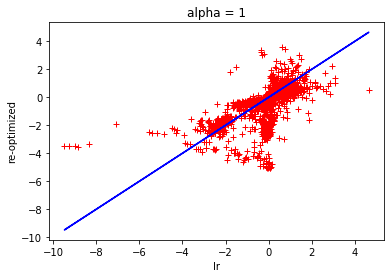

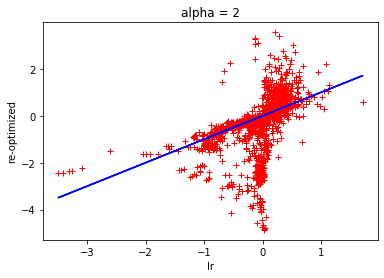

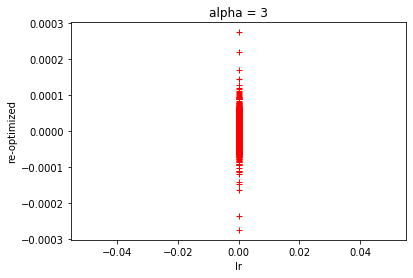

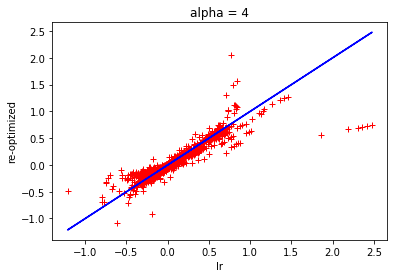

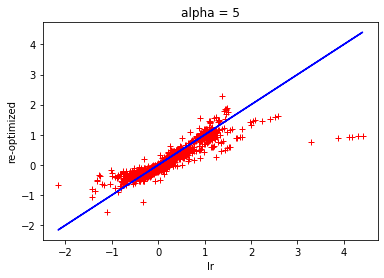

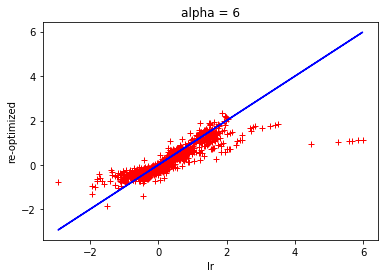

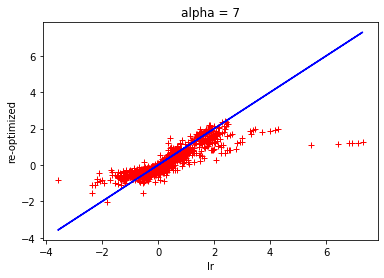

In [45]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [46]:
import numpy as onp

In [47]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(pert_dict)
    lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(lr_dict)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


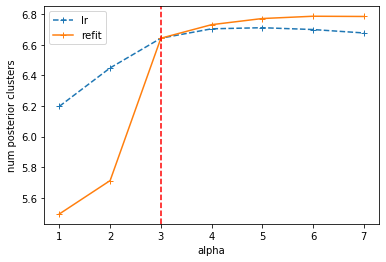

In [48]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')